In [1]:
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


A 10th magnitude V band source:

In [2]:
n = 5
src = ceo.Source("V",resolution=(n+1,n+1))
src.magnitude = [10]

A single lenslet Shack-Hartmann WFS with $4\times 4$ pixel in the pupil plane and a Nyquist sampled focal plane with $8\times 8$ pixels:

In [3]:
wfs = ceo.ShackHartmann(1,n,1,N_PX_IMAGE=2*(n+1))

A 1m$^2$ square pupil:

In [4]:
tel = ceo.Mask(n+1,1)

for the source to go through

In [5]:
src.masked(tel)

Lets calibrate the WFS:

In [6]:
wfs.calibrate(src,1)

The WFS detector is reset, the source is propagated through the WFS and the WFS detector is read (the exposure time is 1ms):

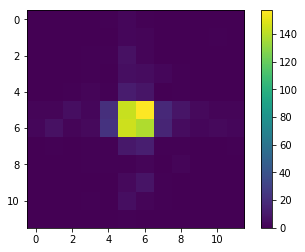

In [7]:
src.magnitude = [10]
wfs.reset()
wfs.propagate(src)
wfs.readOut(1e-3,0)
frame = wfs.frame
imshow(frame.host(),interpolation='none')
colorbar()

In [8]:
np.sum(frame.host_data)

847.0

In [9]:
src.nPhoton*1e-3

array([ 897.])

The WFS detector frame is process to get the centroids:

In [11]:
wfs.process()
print(wfs.c.host(units='arcsec')*1e3)

[[-1.57378888 -1.17194343]]


In [12]:
def wfeVsNoise(magnitude,ron=0,exposure=1e-3):
    src.magnitude = [magnitude]
    nSample = 2500
    cx = np.zeros(nSample)
    cy = np.zeros(nSample)
    for k in range(nSample):
        wfs.reset()
        wfs.propagate(src)
        wfs.readOut(exposure,ron)
        wfs.process()
        c = wfs.c.host()
        cx[k] = c[0,0]
        cy[k] = c[0,1]    
    return src.nPhoton*exposure, cx.var(), cy.var()

## Centroiding error versus photon noise

### Analytical expression

In [13]:
def photonNoise(nPh,fwhm):
    return ((fwhm**2/(4*math.log(2)))/nPh)

### Numerical estimation

In [16]:
magnitude = np.linspace(0,14,15)
print(magnitude)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.]


In [19]:
cex = np.zeros(magnitude.size)
cey = np.zeros(magnitude.size)
nPh = np.zeros(magnitude.size)
for x in range(magnitude.size):
    nPh[x], cex[x],cey[x] = wfeVsNoise(x)
print(nPh)

[  8.97000038e+06   3.57102157e+06   1.42164928e+06   5.65968704e+05
   2.25316208e+05   8.97000000e+04   3.57102040e+04   1.42164940e+04
   5.65968750e+03   2.25316275e+03   8.97000000e+02   3.57102062e+02
   1.42164875e+02   5.65969023e+01   2.25316270e+01]


In [20]:
px_scale = 0.55e-6/2
fwhm = 2*px_scale
i_nPh = 1.0/nPh
u = cex/fwhm**2
v = cey/fwhm**2
px = polyfit(i_nPh , u,1)
py = polyfit(i_nPh , v,1)
print(px, py)

[  4.50583337e-01  -4.91398632e-05] [  4.24288142e-01  -1.37810336e-05]


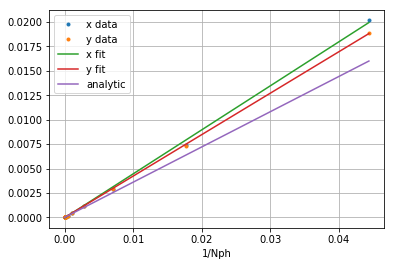

In [21]:
fig, ax = plt.subplots()
ax.plot(i_nPh,u,'.',label='x data')
ax.plot(i_nPh,v,'.',label='y data')
ax.plot(i_nPh,px[0]/nPh + px[1],label='x fit')
ax.plot(i_nPh,py[0]/nPh + py[1],label='y fit')
ax.plot(i_nPh,photonNoise(nPh,fwhm)/fwhm**2,label='analytic')
ax,grid()
ax.set_xlabel('1/Nph')
ax.legend(loc=0)

# Centroiding error versus read-out noise

### Analytical expression

In [22]:
def readOutNoise(ron,pxScale,nPh,Ns):
    return (pxScale*ron/nPh)**2*Ns**4/12

### Numerical estimation

In [24]:
ron = np.linspace(0,10,11)
print(ron)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]


In [25]:
cex = np.zeros(ron.size)
cey = np.zeros(ron.size)
nPh = np.zeros(ron.size)
for x in range(ron.size):
    nPh[x], cex[x],cey[x] = wfeVsNoise(8,ron=x)

In [27]:
u = nPh[0]**2*cex/px_scale**2
v = nPh[0]**2*cey/px_scale**2
ron2 = ron**2
px = polyfit(ron2 , u,1)
py = polyfit(ron2 , v,1)
print(px, py)

[ 1746.74107737  9085.3415336 ] [ 1760.75274942  9077.69677875]


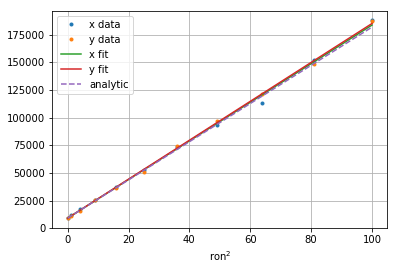

In [28]:
fig, ax = plt.subplots()
ax.plot(ron2,u,'.',label='x data')
ax.plot(ron2,v,'.',label='y data')
ax.plot(ron2,px[0]*ron2 + px[1],label='x fit')
ax.plot(ron2,py[0]*ron2 + py[1],label='y fit')
ax.plot(ron2,nPh[0]**2*readOutNoise(ron,px_scale,nPh[0],(n+1)*2)/px_scale**2+0.5*(px[1]+py[1]),'--',label='analytic')
ax.grid()
ax.set_xlabel('ron$^2$')
ax.legend(loc=0)

In [ ]:
0.25/math.log(2)

In [ ]:
(2*n)**4/12